In [1]:
#pull data from finance yahoo news using api, convert the file to json and then a list of all news for a particular stocks, for this example, tesla. 
import requests
!pip install newsapi-python
!pip install yfinance
import yfinance as yf
from newsapi import NewsApiClient
from urllib.request import urlopen, Request
!pip install bs4
from bs4 import BeautifulSoup
import json
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
!pip install TextBlob
from textblob import TextBlob
#!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




Try a different data set, hopefully data size will be much bigger


## get news data using news api
api = NewsApiClient(api_key='9ab1bcf601ca4f80b15327966b2c3229')
tsla_articles = api.get_everything(q='tesla', sources = 'bbc news, metro, financial-times, business insider, yahoo finance, reuters, bloomberg,cnbc,fortune,cbc-news',
                                   from_param='2020-09-01', to='2020-10-20',
                                   language='en'
                                   )

In [2]:
'''api = NewsApiClient(api_key='9ab1bcf601ca4f80b15327966b2c3229') 
tsla_articles = api.get_everything(everything?q='tesla', sources = 'bbc news,finviz, metro, financial-times, business insider, yahoo finance, reuters, bloomberg,cnbc,fortune,cbc-news', 
                                   from_param='2020-09-21', to='2020-10-21', 
                                   language='en' 
                                  )
print(len(tsla_articles['articles']))'''
api_key = '92ca98e398914d28a60d029d8bfc40af'
url = 'https://newsapi.org/v2/everything?q=tesla'

parameters = { 
             'q':'tesla',
             'pagesize':100,
              'apiKey':api_key,
              'language':'en',
              'from':'2020-10-12'
              }
tsla_articles = requests.get(url, params = parameters).json()
print(tsla_articles['articles'])

[{'source': {'id': 'engadget', 'name': 'Engadget'}, 'author': 'Igor Bonifacic', 'title': 'Tesla reportedly stops offering its seven-day return policy', 'description': 'Tesla has stopped offering its seven-day, no questions asked return policy, according to Electrek. The company reportedly put an end to the offer last night. Visiting the webpage the automaker had dedicated to the policy now redirects to Tesla’s homepage. Can…', 'url': 'https://www.engadget.com/tesla-seven-day-return-policy-200222287.html', 'urlToImage': 'https://o.aolcdn.com/images/dims?resize=1200%2C630&crop=1200%2C630%2C0%2C0&quality=95&image_uri=https%3A%2F%2Fs.yimg.com%2Fos%2Fcreatr-uploaded-images%2F2020-10%2Fa6f5bf70-0fe6-11eb-bfb7-92e38290b660&client=amp-blogside-v2&signature=7a789e0c714facad78d6833dca8eb0f74d265bdd', 'publishedAt': '2020-10-16T20:02:22Z', 'content': 'Tesla has stopped offering its seven-day, no questions asked return policy, according to Electrek. The company reportedly put an end to the offer l

In [3]:
#extract news from the list tsla_articles['articles']
dic_tsla={'title':[],'date':[]}
for news in tsla_articles['articles']:
    dic_tsla['title'].append(news['title'])
    dic_tsla['date'].append(news['publishedAt'])
tsla_news = pd.DataFrame(dic_tsla,columns=['date','title']).sort_values('date').reset_index()
del tsla_news['index']

tsla_news['date'] = pd.to_datetime(tsla_news['date'])
tsla_news['date'] = [d.date() for d in tsla_news['date']]
print(tsla_news)

          date                                              title
0   2020-10-12  LG Chem says third-quarter operating profit li...
1   2020-10-12  Tesla to launch Full Self Driving beta to sele...
2   2020-10-12  Tesla's 'Full Self-Driving' beta releases to s...
3   2020-10-13  Tesla cuts prices of Model S variant in United...
4   2020-10-13  Tesla cuts prices of Model S variant in United...
..         ...                                                ...
95  2020-11-11  BMW unveils electric SUV to challenge Tesla, p...
96  2020-11-11  BMW unveils electric SUV to challenge Tesla, p...
97  2020-11-11  BMW unveils electric SUV to challenge Tesla, p...
98  2020-11-11                Report: Elon Musk Is Kind of a Dick
99  2020-11-12  Mercedes-Benz Berlin plant boss to join Tesla,...

[100 rows x 2 columns]


In [4]:
#concatenate all titles with same date using join
tsla_news['title'] = tsla_news['title'].astype(str)
tsla_news = tsla_news.groupby('date').agg({'title':','.join}).reset_index()
#further work, data might need to be cleaned
#print(tsla_news.iloc[3,0])
print(tsla_news)

          date                                              title
0   2020-10-12  LG Chem says third-quarter operating profit li...
1   2020-10-13  Tesla cuts prices of Model S variant in United...
2   2020-10-14  Lucid reveals the price of its base Air sedan ...
3   2020-10-15  Tesla will start making seven-seater Model Ys ...
4   2020-10-16  Tesla Model 3 2021 refresh offers more range a...
5   2020-10-17  Tesla's 'try it for a week' return policy is o...
6   2020-10-18  After Math: Apple's unveils its inaugural 5G p...
7   2020-10-19  Tesla to export China-made Model 3 vehicles to...
8   2020-10-20  Tesla third-quarter registrations in Californi...
9   2020-10-21  GMC reveals the Hummer EV: 1,000 HP, 350 mile ...
10  2020-10-22  This former Tesla CIO just raised $150 million...
11  2020-10-23  Maharashtra invites Tesla after Musk hints ent...
12  2020-10-24  Tesla Full Self-Driving (FSD) Beta Testers Sha...
13  2020-10-28  Report: Tesla Autopilot has best performance—G...
14  2020-1

In [5]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [6]:
#compute sentiment scores using subjectivity and polarity
vader = SentimentIntensityAnalyzer()
#f = lambda title: vader.polarity_scores(title)['compound'] # only compute the 'compound' component 
tsla_news['subjectivity']= tsla_news['title'].apply(get_subjectivity)
tsla_news['polarity']= tsla_news['title'].apply(get_subjectivity)


In [7]:
def compute_sentiment_scores(text):
    vader = SentimentIntensityAnalyzer()
    return vader.polarity_scores(text)
    
    

In [8]:
#compute sentiment scores using vader
compound=[]
neg=[]
pos=[]
neu=[]
res=0

for i in range(0, len(tsla_news['title'])):
    res = compute_sentiment_scores(tsla_news['title'][i])
    compound.append(res['compound'])
    neg.append(res['neg'])
    pos.append(res['pos'])
    neu.append(res['neu'])
    
    



In [9]:
#store this sentiment scores to tsla_news
tsla_news['compound']=compound
tsla_news['neg']=neg
tsla_news['pos']=pos
tsla_news['neu']=neu
print(tsla_news)

          date                                              title  \
0   2020-10-12  LG Chem says third-quarter operating profit li...   
1   2020-10-13  Tesla cuts prices of Model S variant in United...   
2   2020-10-14  Lucid reveals the price of its base Air sedan ...   
3   2020-10-15  Tesla will start making seven-seater Model Ys ...   
4   2020-10-16  Tesla Model 3 2021 refresh offers more range a...   
5   2020-10-17  Tesla's 'try it for a week' return policy is o...   
6   2020-10-18  After Math: Apple's unveils its inaugural 5G p...   
7   2020-10-19  Tesla to export China-made Model 3 vehicles to...   
8   2020-10-20  Tesla third-quarter registrations in Californi...   
9   2020-10-21  GMC reveals the Hummer EV: 1,000 HP, 350 mile ...   
10  2020-10-22  This former Tesla CIO just raised $150 million...   
11  2020-10-23  Maharashtra invites Tesla after Musk hints ent...   
12  2020-10-24  Tesla Full Self-Driving (FSD) Beta Testers Sha...   
13  2020-10-28  Report: Tesla Auto

In [10]:
tsla_stock_df = yf.Ticker('tsla')
tsla_stock_df = tsla_stock_df.history(period='1mo').reset_index()
tsla_stock_df = tsla_stock_df[['Date','Open','High','Low','Close','Volume']]
tsla_stock_df = tsla_stock_df.rename(columns={'Date': 'date', 'Open': 'open','High':'high','Low':'low',
                                              'Close':'close','Volume':'volume'})
print(tsla_stock_df)

         date        open        high         low       close    volume
0  2020-10-12  442.000000  448.739990  438.579987  442.299988  38791100
1  2020-10-13  443.350006  448.890015  436.600006  446.649994  34463700
2  2020-10-14  449.779999  465.899994  447.350006  461.299988  48045400
3  2020-10-15  450.309998  456.570007  442.500000  448.880005  35672400
4  2020-10-16  454.440002  455.950012  438.850006  439.670013  32775900
5  2020-10-19  446.239990  447.000000  428.869995  430.829987  36287800
6  2020-10-20  431.750000  431.750000  419.049988  421.940002  31656300
7  2020-10-21  422.700012  432.950012  421.250000  422.640015  32370500
8  2020-10-22  441.920013  445.230011  424.510010  425.790009  39993200
9  2020-10-23  421.839996  422.890015  407.380005  420.630005  33717000
10 2020-10-26  411.630005  425.760010  410.000000  420.279999  28239200
11 2020-10-27  423.760010  430.500000  420.100006  424.679993  22686500
12 2020-10-28  416.480011  418.600006  406.000000  406.019989  2

In [11]:
#merge with dataframe of tesla daily stock price
tsla_news['date']=pd.to_datetime(tsla_news['date'])
tsla_news_sentiment = tsla_news.merge(tsla_stock_df, how='inner', on='date')
tsla_news_sentiment=tsla_news_sentiment[['date','open','high','low','volume','subjectivity','polarity',
                                         'compound','neg','pos','neu','close']]
#tsla_news_sentiment=tsla_news_sentiment.groupby('date').agg({'compound':'mean'})
tsla_news_sentiment = tsla_news_sentiment.set_index('date')
print(tsla_news_sentiment)
#print(tsla_news_sentiment.shape)

                  open        high         low    volume  subjectivity  \
date                                                                     
2020-10-12  442.000000  448.739990  438.579987  38791100      0.420000   
2020-10-13  443.350006  448.890015  436.600006  34463700      0.142857   
2020-10-14  449.779999  465.899994  447.350006  48045400      0.380000   
2020-10-15  450.309998  456.570007  442.500000  35672400      0.000000   
2020-10-16  454.440002  455.950012  438.850006  32775900      0.300000   
2020-10-19  446.239990  447.000000  428.869995  36287800      0.000000   
2020-10-20  431.750000  431.750000  419.049988  31656300      0.000000   
2020-10-21  422.700012  432.950012  421.250000  32370500      0.481710   
2020-10-22  441.920013  445.230011  424.510010  39993200      0.213973   
2020-10-23  421.839996  422.890015  407.380005  33717000      0.000000   
2020-10-28  416.480011  418.600006  406.000000  25451400      0.483333   
2020-10-29  409.959991  418.059998  40

In [12]:
#EDA 
#use info to check this dataframe
tsla_news_sentiment.info() #everything looks good

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2020-10-12 to 2020-11-11
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          20 non-null     float64
 1   high          20 non-null     float64
 2   low           20 non-null     float64
 3   volume        20 non-null     int64  
 4   subjectivity  20 non-null     float64
 5   polarity      20 non-null     float64
 6   compound      20 non-null     float64
 7   neg           20 non-null     float64
 8   pos           20 non-null     float64
 9   neu           20 non-null     float64
 10  close         20 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 1.9 KB


In [13]:
#look at dimension
tsla_news_sentiment.shape

(20, 11)

In [14]:
#check correlation of this dataframe
tsla_news_sentiment.corr()

,open,high,low,volume,subjectivity,polarity,compound,neg,pos,neu,close
open,1.000000,0.943902,0.912007,0.404798,-0.500746,-0.500746,-0.140691,0.169317,-0.176162,0.025035,0.825507
high,0.943902,1.000000,0.941121,0.482880,-0.389854,-0.389854,-0.149181,0.139382,-0.154061,0.026996,0.900814
low,0.912007,0.941121,1.000000,0.288237,-0.312688,-0.312688,-0.050548,0.131852,-0.073477,-0.022417,0.954841
volume,0.404798,0.482880,0.288237,1.000000,-0.139800,-0.139800,-0.187808,0.163901,-0.120213,-0.008693,0.338491
subjectivity,-0.500746,-0.389854,-0.312688,-0.139800,1.000000,1.000000,0.198535,-0.215908,0.128806,0.033065,-0.261606
polarity,-0.500746,-0.389854,-0.312688,-0.139800,1.000000,1.000000,0.198535,-0.215908,0.128806,0.033065,-0.261606
compound,-0.140691,-0.149181,-0.050548,-0.187808,0.198535,0.198535,1.000000,-0.377099,0.534835,-0.149706,-0.163581
neg,0.169317,0.139382,0.131852,0.163901,-0.215908,-0.215908,-0.377099,1.000000,0.357618,-0.784060,0.159021
pos,-0.176162,-0.154061,-0.073477,-0.120213,0.128806,0.128806,0.534835,0.357618,1.000000,-0.860027,-0.104390
neu,0.025035,0.026996,-0.022417,-0.008693,0.033065,0.033065,-0.149706,-0.784060,-0.860027,1.000000,-0.016478


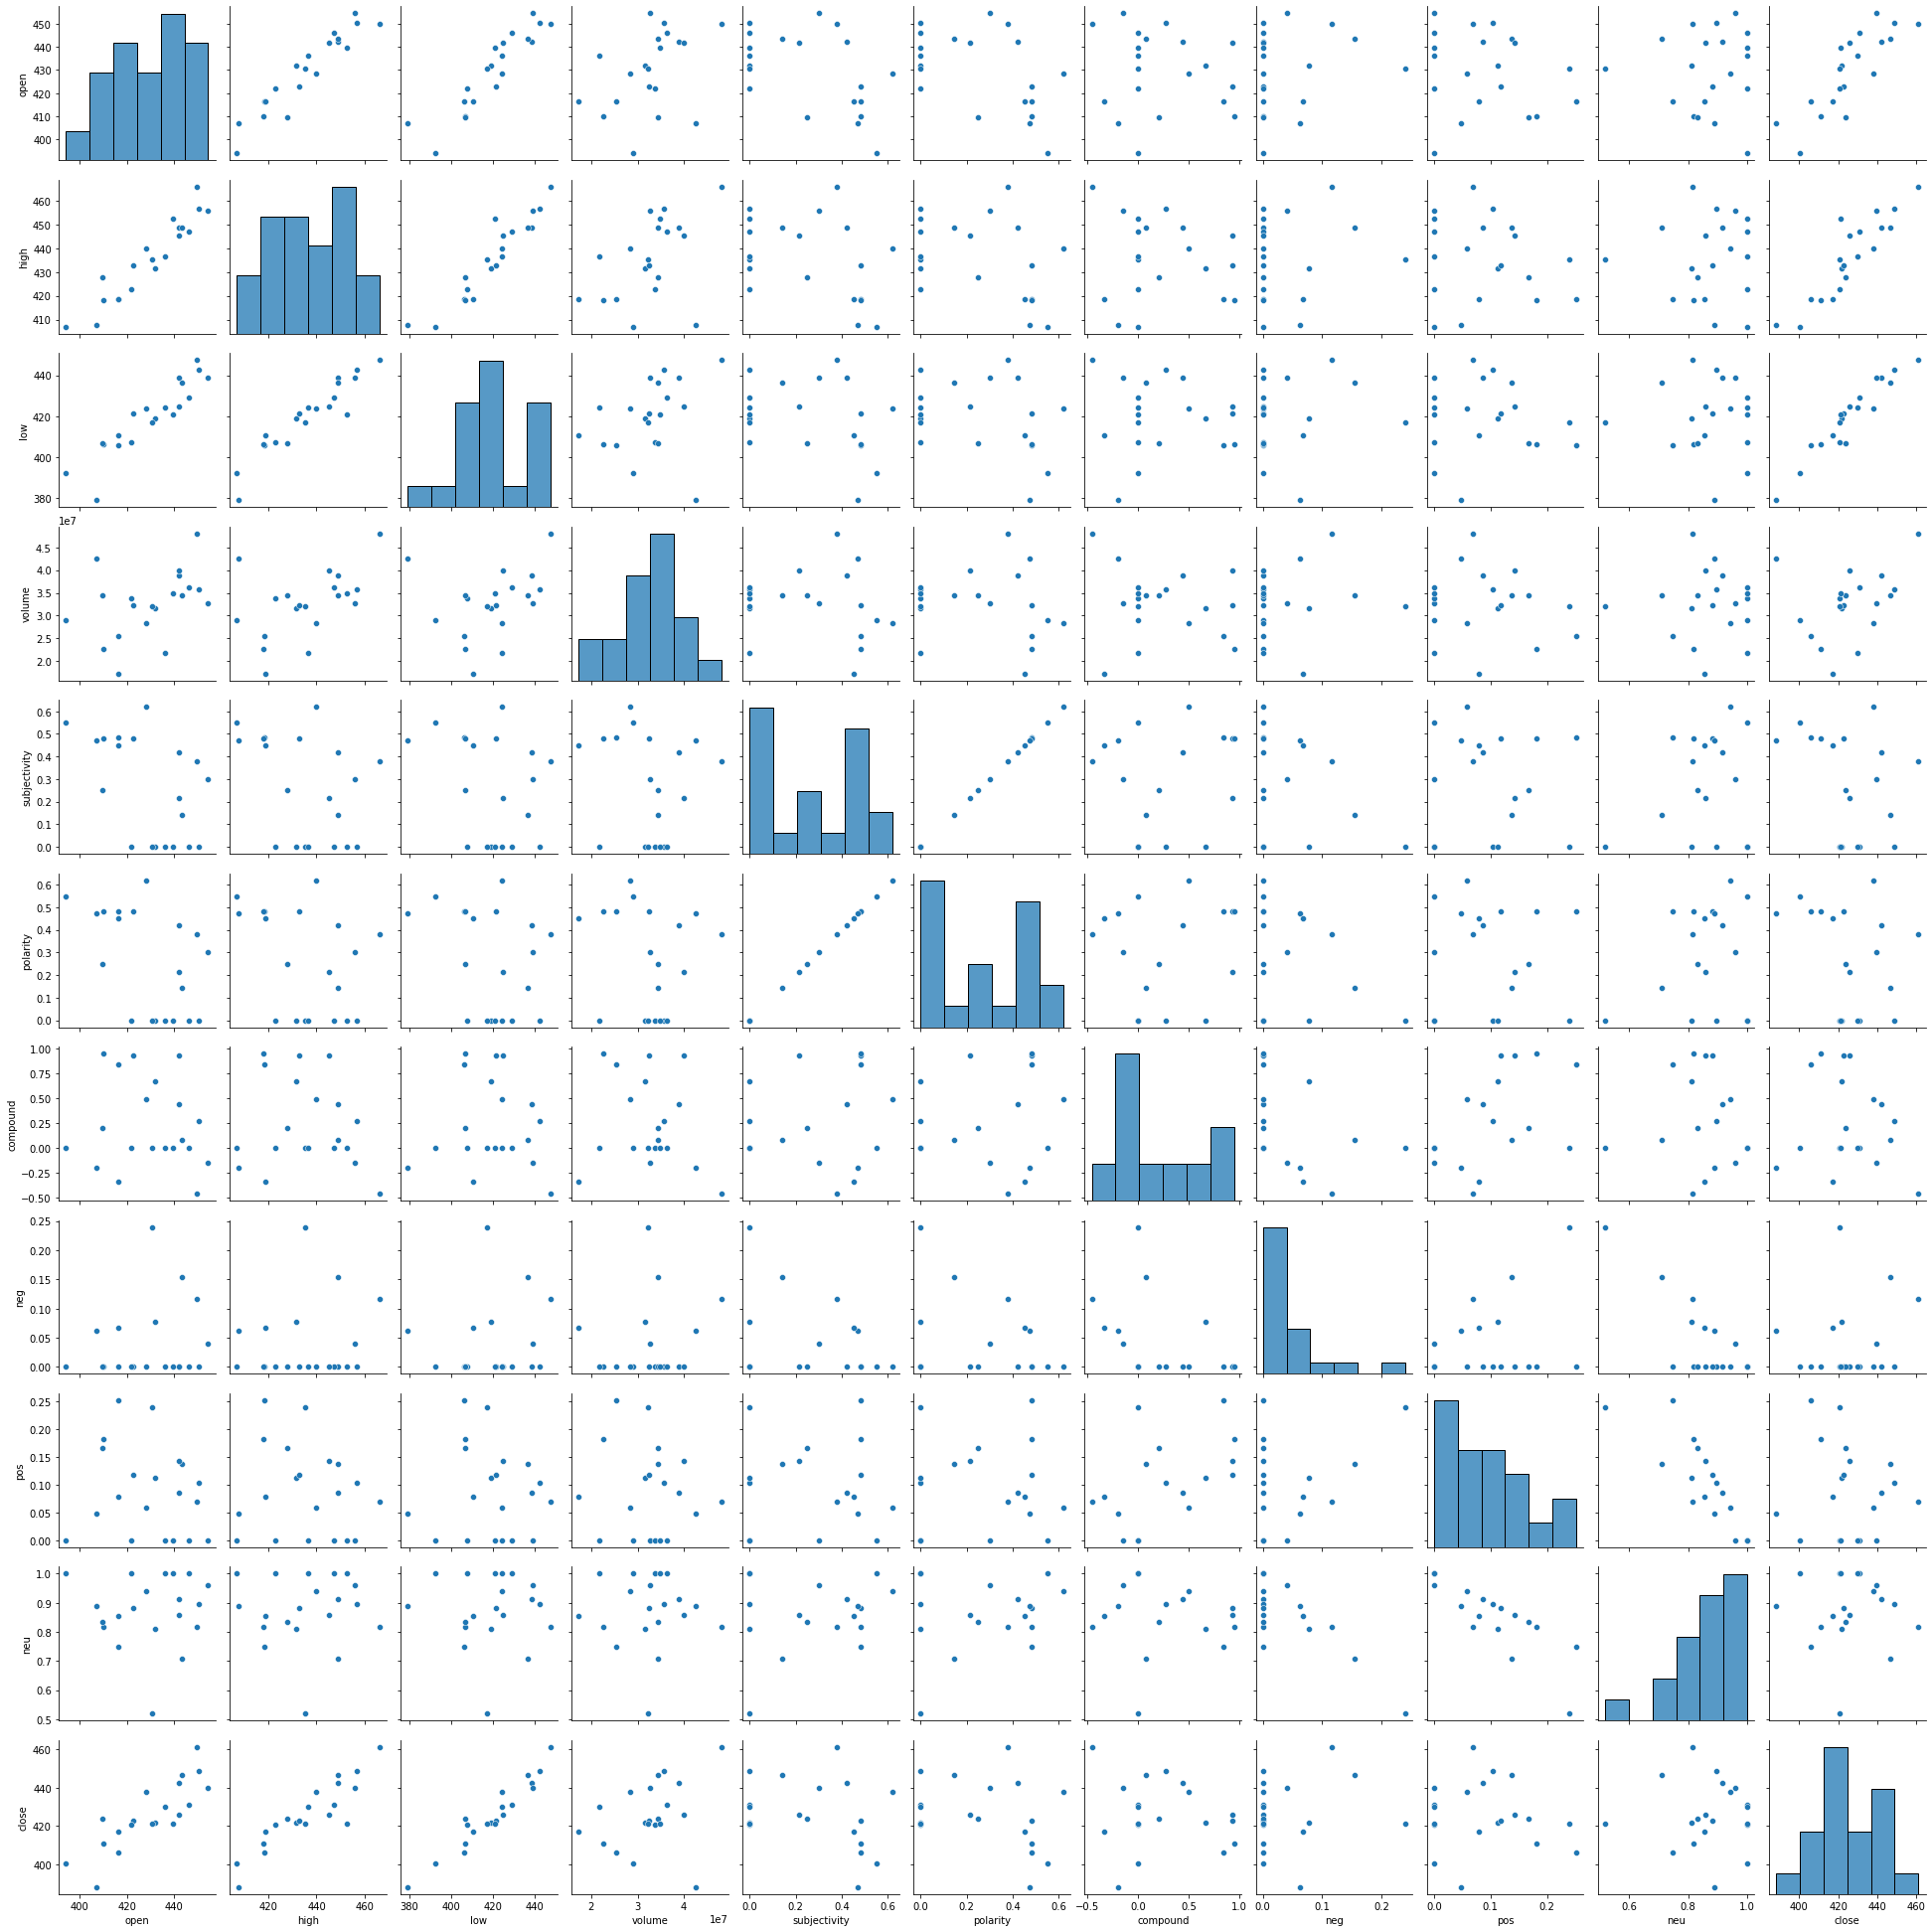

In [15]:
#visualization of this correlation
sns.pairplot(tsla_news_sentiment)

<AxesSubplot:>

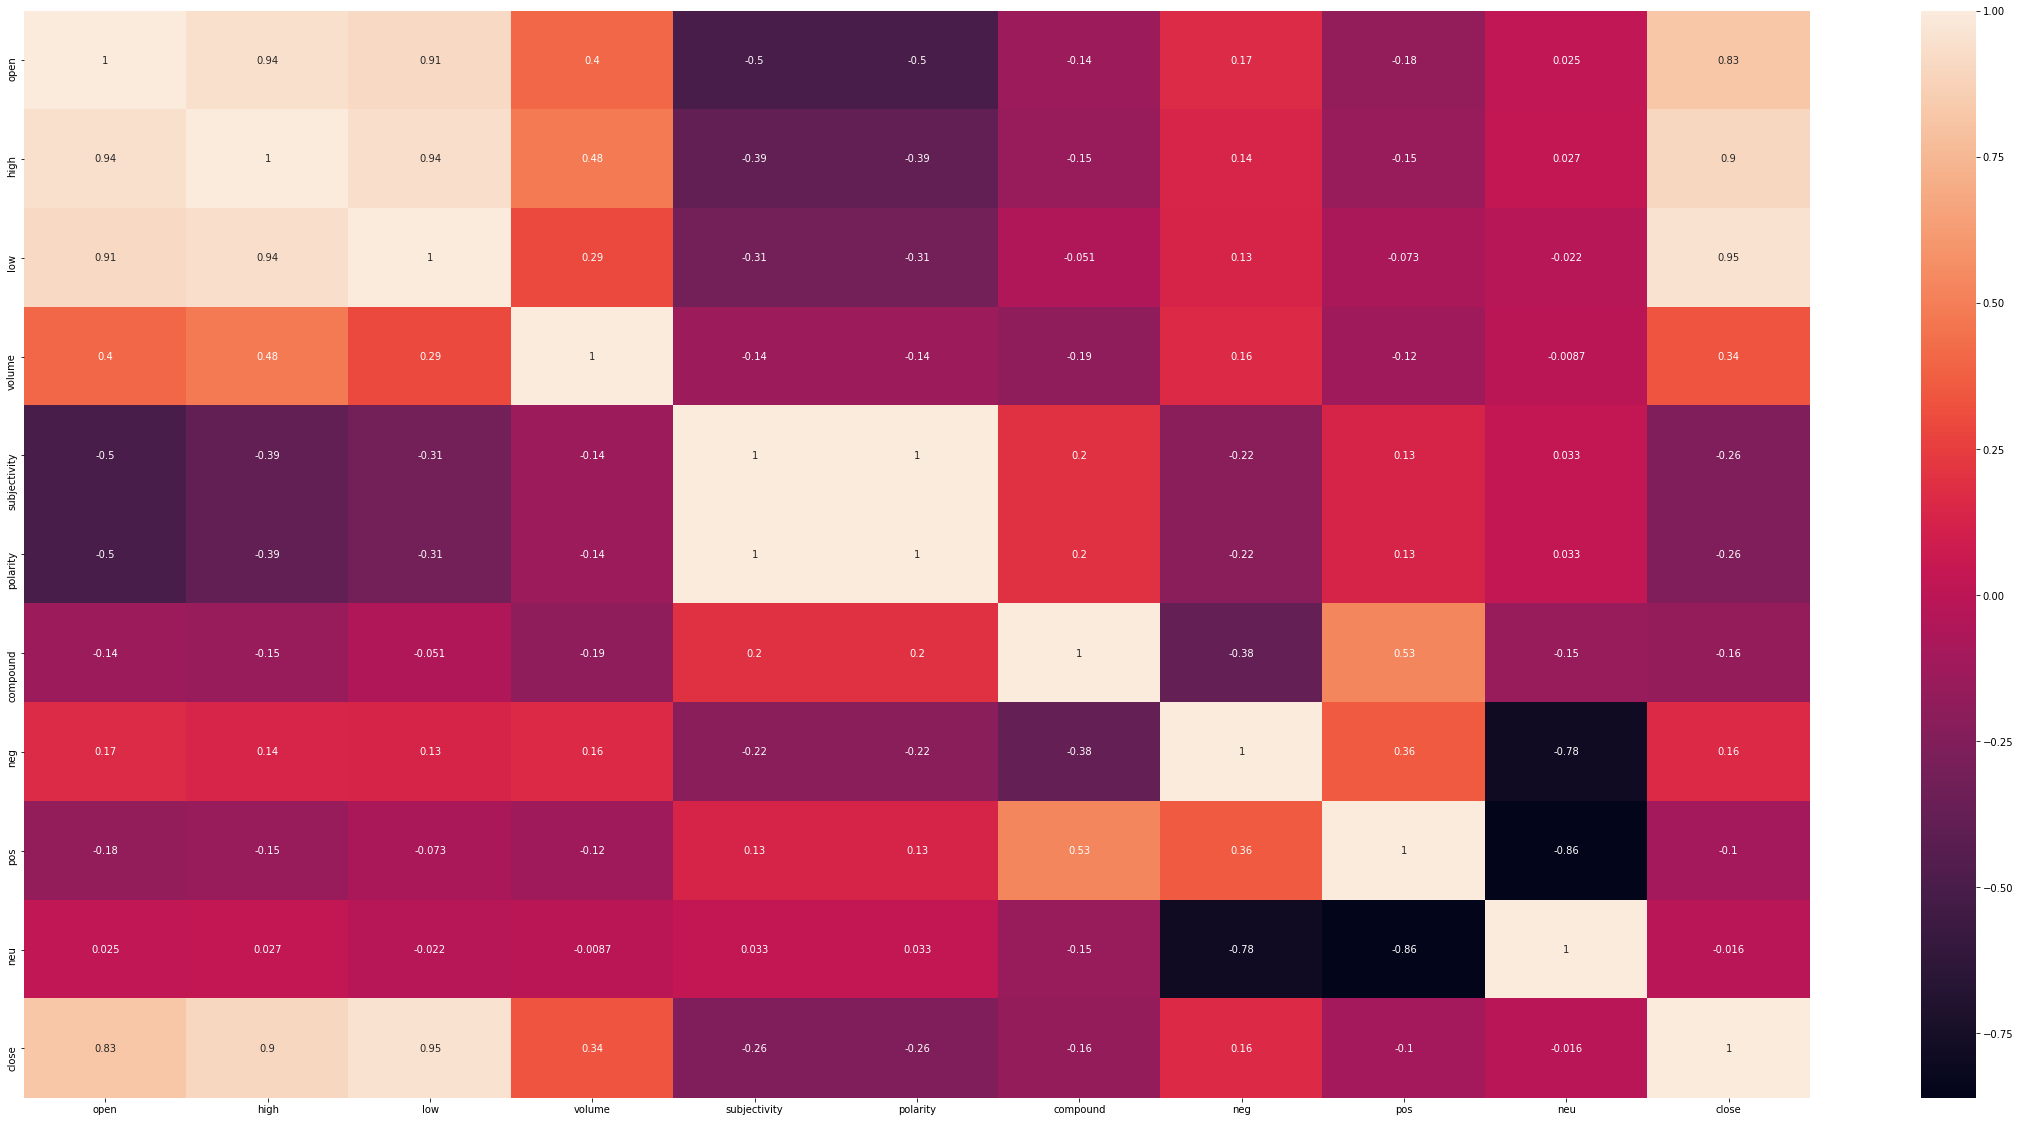

In [16]:
#look at heatmap
plt.figure(figsize=(40,20))
sns.heatmap(tsla_news_sentiment.corr(),annot=True)

In [17]:
#create a column called price_change, indicate increase or decrease of stock price
tsla_news_sentiment['price_change']=0
print(tsla_news_sentiment.dtypes)
#tsla_news_sentiment['price_change']=tsla_news_sentiment['price_change'].fillna(0).astype(int)
tsla_news_sentiment.iloc[0,11]=1 #since tsla stock increased from 2020-9-18 to 2020-9-21
begin_price=449.390015
for index,price in enumerate(tsla_news_sentiment['close'][1:]):
    if price> begin_price:
        tsla_news_sentiment.iloc[index+1,11]=1
    else:
        tsla_news_sentiment.iloc[index+1,11]=0
    begin_price = price
#tsla_news_sentiment.set_index('date', inplace=True)
print(tsla_news_sentiment)    
    

open            float64
high            float64
low             float64
volume            int64
subjectivity    float64
polarity        float64
compound        float64
neg             float64
pos             float64
neu             float64
close           float64
price_change      int64
dtype: object
                  open        high         low    volume  subjectivity  \
date                                                                     
2020-10-12  442.000000  448.739990  438.579987  38791100      0.420000   
2020-10-13  443.350006  448.890015  436.600006  34463700      0.142857   
2020-10-14  449.779999  465.899994  447.350006  48045400      0.380000   
2020-10-15  450.309998  456.570007  442.500000  35672400      0.000000   
2020-10-16  454.440002  455.950012  438.850006  32775900      0.300000   
2020-10-19  446.239990  447.000000  428.869995  36287800      0.000000   
2020-10-20  431.750000  431.750000  419.049988  31656300      0.000000   
2020-10-21  422.700012  432.9500

In [18]:
#feature data set
X = tsla_news_sentiment
X = np.array(X.drop(['price_change'],1))
#target data
Y = np.array(tsla_news_sentiment['price_change'])

In [19]:
#split to 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

In [20]:
#train the model
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

C:\Users\zcj10\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [21]:
#do prediction
prediction = model.predict(x_test)
prediction

array([0, 0, 0, 0], dtype=int64)

In [22]:
y_test

array([0, 0, 0, 1], dtype=int64)

In [23]:
#show model performance
print(classification_report(y_test,prediction)) #performance is pretty good!

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



C:\Users\zcj10\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
